In [57]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import re
from nltk.corpus import stopwords
from collections import Counter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import gensim
from gensim.models import Word2Vec
from sklearn.metrics import roc_auc_score, f1_score
from torchmetrics import F1Score, AUROC
import random

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [58]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.random.manual_seed(seed)
torch.cuda.random.manual_seed(seed)
torch.cuda.random.manual_seed_all(seed)

In [6]:
df1 = pd.read_csv("FakeNewsNet.csv")
df1.head()

,title,news_url,source_domain,tweet_num,real
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1


In [7]:
df1[df1["real"]==0].head()

,title,news_url,source_domain,tweet_num,real
5,Gwen Stefani Got Dumped by Blake Shelton Over ...,www.intouchweekly.com/posts/gwen-stefani-dumpe...,www.intouchweekly.com,45,0
6,Broward County Sheriff Fired For Lying About P...,https://yournewswire.com/broward-county-sherif...,yournewswire.com,124,0
7,Amber Rose Shuts Down French Montana Dating Ru...,www.etonline.com/news/214798_amber_rose_shuts_...,www.etonline.com,4,0
11,Mel Gibson: Hollywood Pedophiles Have Nowhere ...,yournewswire.com/mel-gibson-hollywood-pedophiles/,yournewswire.com,95,0
15,5 Reasons Why Tarek El Moussa Will Overcome Hi...,www.eonline.com/news/932478/5-reasons-why-tare...,www.eonline.com,63,0


In [8]:
df1.shape

(23196, 5)

In [9]:
df = df1.drop(columns = "tweet_num")
df.head()

,title,news_url,source_domain,real
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,1
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,1
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,1


In [10]:
df.isna().sum()

title              0
news_url         330
source_domain    330
real               0
dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23196 entries, 0 to 23195
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          23196 non-null  object
 1   news_url       22866 non-null  object
 2   source_domain  22866 non-null  object
 3   real           23196 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 725.0+ KB


In [12]:
drop_index = df[df["news_url"].isnull()|df["source_domain"].isnull()].index.to_list()
df = df.drop(index=drop_index)
df.shape

(22866, 4)

In [13]:
df.isna().sum()

title            0
news_url         0
source_domain    0
real             0
dtype: int64

In [14]:
df["real"].value_counts(normalize=True)

real
1    0.759687
0    0.240313
Name: proportion, dtype: float64

In [15]:
df["text"] = df["source_domain"]+" "+df["title"]+" "+df["news_url"]


In [16]:
df.head()

,title,news_url,source_domain,real,text
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,1,toofab.com Kandi Burruss Explodes Over Rape Ac...
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,1,www.today.com People's Choice Awards 2018: The...
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,1,www.etonline.com Sophia Bush Sends Sweet Birth...
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,1,www.dailymail.co.uk Colombian singer Maluma sp...
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,1,www.zerchoo.com Gossip Girl 10 Years Later: Ho...


In [17]:
df["text"][np.random.randint(df.shape[0])]

'www.bostonmagazine.com Aly Raisman Calls Out U.S. Olympic Committee for “Shameless” Statement https://www.bostonmagazine.com/news/2018/01/23/raisman-usoc-nassar-hearing/'

In [633]:
df_total = df.copy()

In [634]:
def processing(data, freq_values):
    def textField(data):
        data = data.str.lower()
        data= data.str.replace(r"[^a-zA-Z\s]"," ", regex=True)
        data= data.str.replace(r"\s+", " ", regex = True)
        data = data.str.split()
        stop_words = stopwords.words("english")
        for i in data.index.tolist():
            l_words = []
            for word in data[i]:
                if  word not in stop_words:
                    l_words.append(word)
            data[i]=l_words
        return data

    data = textField(data)


    def textVocab(data):
        l_words, a1 = [], []
        d_words = {}
        l_keys = ["<pad>","<unk>"]
        for i in data.index.tolist():
            for word in data[i]:
                l_words.append(word)
        freq_words = Counter(l_words)
        a = list(freq_words.items())
        for i  in range(len(a)):
            for j in range(len(a)):
                if a[j][1] < a[i][1]:
                    a[i],a[j]=a[j],a[i]
        for i in range(len(a)):
            a1.append(a[i][1])
            b = sum(a1)/len(l_words)*100
            if  a[i][1]>freq_values:
                l_keys.append(a[i][0])
        for i, word in enumerate(l_keys):
            d_words[word] = i
        return d_words
        
    d_words = textVocab(data)
        
    return data, d_words

In [636]:
freq_values = 1

In [637]:
df_total["textField"], d_words= processing(df_total["text"], freq_values=freq_values)

In [638]:
df_total["textField"]

0        [toofab, com, kandi, burruss, explodes, rape, ...
1        [www, today, com, people, choice, awards, best...
2        [www, etonline, com, sophia, bush, sends, swee...
3        [www, dailymail, co, uk, colombian, singer, ma...
4        [www, zerchoo, com, gossip, girl, years, later...
                               ...                        
23191    [www, express, co, uk, pippa, middleton, weddi...
23192    [hollywoodlife, com, zayn, malik, gigi, hadid,...
23193    [www, justjared, com, jessica, chastain, recal...
23194    [www, intouchweekly, com, tristan, thompson, f...
23195    [www, billboard, com, kelly, clarkson, perform...
Name: textField, Length: 22866, dtype: object

In [639]:
df_total["textField"][0]

['toofab',
 'com',
 'kandi',
 'burruss',
 'explodes',
 'rape',
 'accusation',
 'real',
 'housewives',
 'atlanta',
 'reunion',
 'video',
 'http',
 'toofab',
 'com',
 'real',
 'housewives',
 'atlanta',
 'kandi',
 'burruss',
 'rape',
 'phaedra',
 'parks',
 'porsha',
 'williams']

In [640]:
len(d_words)

17729

In [641]:
df_total["realField"]=df_total["real"].apply(lambda x : 1 if x==0 else 0)

In [642]:
df_total["realField"].value_counts(normalize=True)

realField
0    0.759687
1    0.240313
Name: proportion, dtype: float64

In [643]:
dataset = df_total.copy()

In [644]:
max_len, max_idx = 0,0
len_list = []
for ind in dataset["textField"].index.tolist():
    len_list.append(len(dataset["textField"][ind]))
    if len(dataset["textField"][ind])>max_len:
        max_len = len(dataset["textField"][ind])
        max_idx = ind
print(max_len,max_idx)        

66 9328


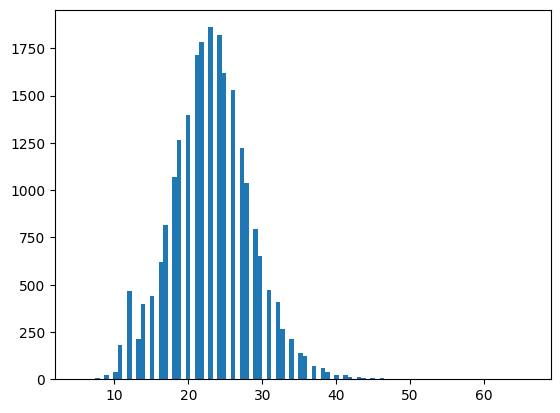

In [645]:
plt.hist(len_list, bins = 100)
plt.show();

In [646]:
dataset["textToNumber"]=dataset["textField"]
l_pad = [0]*70
l_wordsToNumber = []
for i  in dataset["textToNumber"].index.tolist():
    l1 = []
    for word in dataset["textToNumber"][i]:
        if word in d_words.keys():
            l1.append(d_words[word])
        else:
            l1.append(d_words["<unk>"])
    l1.extend(l_pad[:(len(l_pad)-(len(l1)))])        
    l_wordsToNumber.append(l1)
dataset["textToNumber"]=l_wordsToNumber
print(dataset["textToNumber"])        

0        [682, 2, 4826, 5165, 5027, 1036, 6258, 105, 22...
1        [3, 100, 2, 6, 293, 30, 48, 107, 126, 231, 4, ...
2        [3, 29, 2, 1479, 1077, 1801, 438, 96, 572, 132...
3        [3, 16, 7, 8, 8082, 486, 3436, 1387, 1430, 311...
4        [3, 613, 2, 567, 247, 119, 1904, 2077, 2286, 1...
                               ...                        
23191    [3, 532, 7, 8, 527, 110, 28, 1020, 1372, 527, ...
23192    [39, 2, 858, 1002, 318, 160, 963, 65, 1442, 74...
23193    [3, 628, 2, 157, 3025, 1120, 713, 353, 166, 17...
23194    [3, 420, 2, 274, 260, 873, 1741, 865, 12, 2010...
23195    [3, 97, 2, 143, 563, 1841, 3540, 2524, 1161, 7...
Name: textToNumber, Length: 22866, dtype: object


In [647]:
len_list = []
for ind in dataset["textToNumber"].index.tolist():
    len_list.append(len(dataset["textToNumber"][ind]))
print(set(len_list))

{70}


In [648]:
data_train, data_test = train_test_split(dataset, test_size=0.2, stratify=dataset["realField"], random_state=42, shuffle=True)

In [649]:
data_train["realField"].value_counts(normalize=True), data_test["realField"].value_counts(normalize=True)

(realField
 0    0.759676
 1    0.240324
 Name: proportion, dtype: float64,
 realField
 0    0.759729
 1    0.240271
 Name: proportion, dtype: float64)

In [650]:
data_train.shape, data_test.shape

((18292, 8), (4574, 8))

In [651]:
train_text_tensor = torch.tensor(data_train["textToNumber"].tolist(), dtype = torch.long)
train_label_tensor = torch.tensor(data_train["realField"].tolist(), dtype = torch.long)
test_text_tensor = torch.tensor(data_test["textToNumber"].tolist(), dtype = torch.long)
test_label_tensor = torch.tensor(data_test["realField"].tolist(), dtype = torch.long)

In [652]:
train_text_tensor, test_text_tensor, train_label_tensor, test_label_tensor

(tensor([[   3,  301,    2,  ...,    0,    0,    0],
         [  13,   21,   10,  ...,    0,    0,    0],
         [3408, 4682,    2,  ...,    0,    0,    0],
         ...,
         [   3,  533,    2,  ...,    0,    0,    0],
         [   3,  413,    2,  ...,    0,    0,    0],
         [  86,  130,   10,  ...,    0,    0,    0]]),
 tensor([[   3,   24,    2,  ...,    0,    0,    0],
         [ 402,    2,   52,  ...,    0,    0,    0],
         [   3,  210,    2,  ...,    0,    0,    0],
         ...,
         [   3, 1519,    2,  ...,    0,    0,    0],
         [   3,  273,    2,  ...,    0,    0,    0],
         [   6,    2,  547,  ...,    0,    0,    0]]),
 tensor([1, 1, 0,  ..., 0, 0, 0]),
 tensor([0, 0, 0,  ..., 0, 0, 0]))

In [653]:
generator = torch.Generator()
generator.manual_seed(seed)

In [785]:
train_iterator = DataLoader(TensorDataset(train_text_tensor, train_label_tensor), batch_size=100, shuffle=True, num_workers=0, generator=generator)
test_iterator = DataLoader(TensorDataset(test_text_tensor, test_label_tensor), batch_size=100)

In [786]:
len(train_iterator),len(test_iterator), len(train_iterator.dataset), len(test_iterator.dataset)

(183, 46, 18292, 4574)

In [787]:
vector_size = 150
wordtovec = Word2Vec(dataset["textField"],vector_size=vector_size, window=6, sg=1, min_count=(freq_values+1), workers=1, seed=seed)
wordtovec.save("wordtovec_model.model")

In [788]:
embedded_matrix =torch.zeros(len(d_words),vector_size)
embedded_matrix[1] = torch.randn(vector_size)
for i, word in enumerate(list(d_words.keys())):
    if i>1:
        embedded_matrix[i] = torch.FloatTensor(wordtovec.wv.get_vector(word))

In [789]:
embedded_matrix

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.4050, -1.0986, -0.8508,  ...,  0.1152,  0.4917,  1.4829],
        [ 0.1598, -0.2971,  0.0455,  ...,  0.0871,  0.1133, -0.3362],
        ...,
        [ 0.0185, -0.1411, -0.0058,  ...,  0.0813,  0.0351, -0.0218],
        [-0.0055, -0.1512,  0.0109,  ...,  0.0266, -0.0077, -0.0229],
        [-0.0200, -0.1460, -0.0188,  ...,  0.0481, -0.0069, -0.0323]])

In [790]:
embedded_matrix.shape

torch.Size([17729, 150])

In [1034]:
class R_net(nn.Module):
    def __init__(self, hidden_dim, output_dim, n_layers, embedded_matrix, dropout):
        super().__init__()
        self.embedded = nn.Embedding.from_pretrained(embedded_matrix,  freeze=False, padding_idx=0)
        self.dropout1 = nn.Dropout(dropout)
        self.rnn = nn.RNN(embedded_matrix.size(1),hidden_dim, n_layers, batch_first = True, dropout = dropout if n_layers > 1 else 0)
        self.dropout2 = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.bn = nn.BatchNorm1d(hidden_dim)

    def forward(self, x):
        x = self.embedded(x)
        x=self.dropout1(x)
        output, hidden= self.rnn(x)
        last_output = output[:,-1,:]
        #last_output = self.bn(last_output)
        x = self.dropout2(last_output)
        
        return self.fc(x)

In [1035]:
def modeling(model, train_iterator, test_iterator, loss_f, optimizer,  early_stop_value, min_epochs):
    acc_train_list, acc_test_list, avg_loss_train_list, avg_loss_test_list, roc_auc_list =[],[],[],[],[]
    iterations , best_roc_auc, f1, test_acc, best_epoch =0, 0, 0, 0, 0
    for epoch in range(100):
        auroc = AUROC(task="binary").to(device)
        score = F1Score(task="binary").to(device)
        model.train()
        correct = 0
        loss_sum = 0
        for step, (data, target) in enumerate(train_iterator):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_f(output, target)
            loss.backward()
            loss_sum += loss.item()
            optimizer.step()
            pred = output.argmax(dim =1)
            correct += pred.eq(target.view_as(pred)).sum().item()
        acc_train = correct/len(train_iterator.dataset)
        acc_train_list.append(acc_train)
        loss_avg_train = loss_sum/len(train_iterator)
        avg_loss_train_list.append(loss_avg_train)
        print(f" for {epoch+1} train_accuracy : {acc_train: .5f}, loss_avg: {loss_avg_train: .5f}")


        model.eval()
        correct = 0
        loss_sum = 0
        for step, (data, target) in enumerate(test_iterator):
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
                loss = loss_f(output, target)
                loss_sum += loss.item()
                pred = output.argmax(dim =1)
                correct += pred.eq(target.view_as(pred)).sum().item()
                probabiliteis = torch.softmax(output, dim = 1)[:,1]
                auroc.update(probabiliteis, target)
                score.update(pred, target)
        ROC_AUC = auroc.compute()
        roc_auc_list.append(ROC_AUC.item())
        f1_score = score.compute()
        acc_test = correct/len(test_iterator.dataset)
        acc_test_list.append(acc_test)
        loss_avg_test = loss_sum/len(test_iterator)
        avg_loss_test_list.append(loss_avg_test)
        print(f"test_accuracy : {acc_test : .5f}, loss_avg: {loss_avg_test: .5f}, ROC_AUC : {ROC_AUC.item(): .5f}, F1 : {f1_score: .5f}")
        if ROC_AUC > 0.90 and abs(acc_test-acc_train)>0.03:
            print(f"модель переобучается, лучшее значение метрики roc-auc: {best_roc_auc:.5f} было достигнуто в {best_epoch} эпохе, значение f1 {f1 : .5f}, точность на тесте: {test_acc : .5f}")
            break
        if ROC_AUC > best_roc_auc and abs(acc_test-acc_train)<0.05:
            best_roc_auc = ROC_AUC
            f1 = f1_score
            test_acc = acc_test
            best_epoch = epoch+1
            iterations = 0
        else:
            iterations +=1


        if iterations >= early_stop_value and (epoch+1) > min_epochs:
            print(f"лучшее значение метрики roc-auc: {best_roc_auc:.5f} было достигнуто в {best_epoch} эпохе, значение f1 {f1 : .5f}, точность на тесте: {test_acc : .5f}")
            break

    return acc_train_list, acc_test_list, avg_loss_train_list, avg_loss_test_list, roc_auc_list


        
            

In [1036]:
model = R_net(90, 2, 3,embedded_matrix , 0.3)
model = model.to(device)
class_weights =torch.tensor([1/0.76, 1/0.24]).to(device)
loss_f = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-3, weight_decay=1e-3)
early_stop_value = 5
min_epochs =30

In [1037]:
acc_train_rnn, acc_test_rnn, avg_loss_train_rnn, avg_loss_test_rnn, roc_auc_rnn = modeling(model, train_iterator, test_iterator, loss_f, optimizer, early_stop_value, min_epochs)

 for 1 train_accuracy :  0.50836, loss_avg:  0.69492
test_accuracy :  0.75973, loss_avg:  0.69314, ROC_AUC :  0.49390, F1 :  0.00000
 for 2 train_accuracy :  0.50776, loss_avg:  0.69417
test_accuracy :  0.75973, loss_avg:  0.69315, ROC_AUC :  0.49379, F1 :  0.00000
 for 3 train_accuracy :  0.53428, loss_avg:  0.69400
test_accuracy :  0.75973, loss_avg:  0.69315, ROC_AUC :  0.51245, F1 :  0.00000
 for 4 train_accuracy :  0.56353, loss_avg:  0.69390
test_accuracy :  0.75973, loss_avg:  0.69315, ROC_AUC :  0.49745, F1 :  0.00000
 for 5 train_accuracy :  0.53674, loss_avg:  0.69360
test_accuracy :  0.75973, loss_avg:  0.69319, ROC_AUC :  0.50785, F1 :  0.00000
 for 6 train_accuracy :  0.49989, loss_avg:  0.69769
test_accuracy :  0.48491, loss_avg:  0.68697, ROC_AUC :  0.57350, F1 :  0.39959
 for 7 train_accuracy :  0.49874, loss_avg:  0.69672
test_accuracy :  0.45190, loss_avg:  0.68431, ROC_AUC :  0.58503, F1 :  0.40295
 for 8 train_accuracy :  0.49923, loss_avg:  0.69346
test_accuracy : 

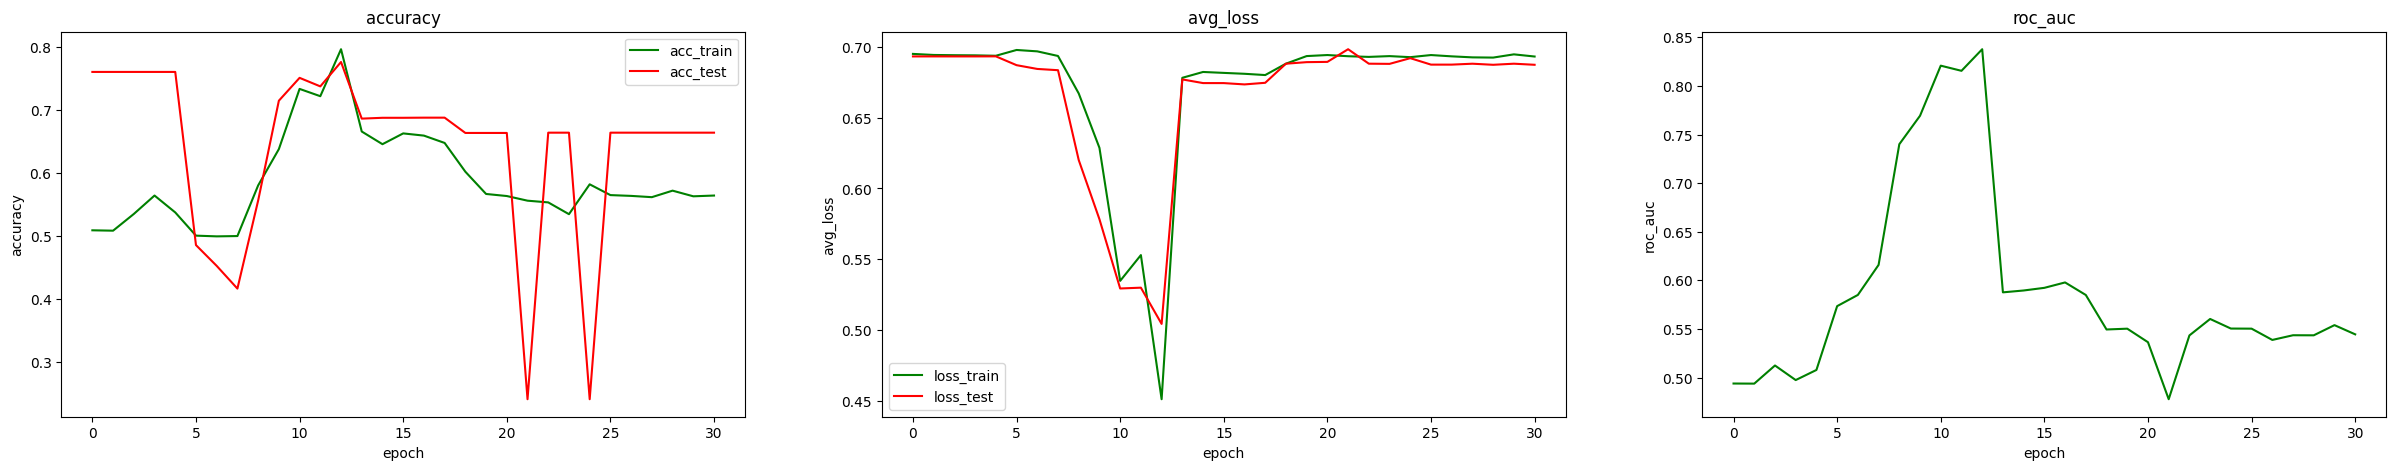

In [1134]:
fig, axs = plt.subplots(1,3, figsize = (30,5))
epoch_rnn = 31
axs[0].plot(range(epoch_rnn), acc_train_rnn, color = "green", label = "acc_train")
axs[0].plot(range(epoch_rnn), acc_test_rnn, color = "red", label = "acc_test")
axs[0].set_xlabel("epoch")
axs[0].set_ylabel("accuracy")
axs[0].set_title("accuracy")
axs[0].legend();

axs[1].plot(range(epoch_rnn), avg_loss_train_rnn, color = "green", label = "loss_train")
axs[1].plot(range(epoch_rnn), avg_loss_test_rnn, color = "red", label = "loss_test")
axs[1].set_xlabel("epoch")
axs[1].set_ylabel("avg_loss")
axs[1].set_title("avg_loss")
axs[1].legend();

axs[2].plot(range(epoch_rnn), roc_auc_rnn, color = "green")
axs[2].set_xlabel("epoch")
axs[2].set_ylabel("roc_auc")
axs[2].set_title("roc_auc");

In [ ]:
embedded_matrix.size(1)

In [1129]:
class LSTM_net(nn.Module):
    def __init__(self, hidden_dim, output_dim, n_layers, embedded_matrix, dropout):
        super().__init__()
        self.embedded = nn.Embedding.from_pretrained(embedded_matrix,  freeze=False, padding_idx=0)
        self.dropout1 = nn.Dropout(dropout)
        self.lstm = nn.LSTM(embedded_matrix.size(1), hidden_dim, n_layers, batch_first = True, dropout = dropout if n_layers > 1 else 0)
        self.dropout2 = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.bn = nn.BatchNorm1d(hidden_dim)

    def forward(self, x):
        x = self.embedded(x)
        x=self.dropout1(x)
        output, (hidden, cell)= self.lstm(x)
        last_output = output[:,-1,:]
        #last_output = self.bn(last_output)
        x = self.dropout2(last_output)
        
        return self.fc(x)

In [1130]:
model1 = LSTM_net(32, 2, 4,embedded_matrix , 0.3)
model1 = model1.to(device)
class_weights =torch.tensor([1/0.76, 1/0.24]).to(device)
loss_f = nn.CrossEntropyLoss(weight=class_weights)
optimizer1 = torch.optim.AdamW(model1.parameters(), lr = 1e-3, weight_decay=1e-3)
early_stop_value = 5
min_epochs =30

In [1131]:
acc_train_lstm, acc_test_lstm, avg_loss_train_lstm, avg_loss_test_lstm, roc_auc_lstm = modeling(model1, train_iterator, test_iterator, loss_f, optimizer1, early_stop_value, min_epochs)

 for 1 train_accuracy :  0.52815, loss_avg:  0.69414
test_accuracy :  0.24027, loss_avg:  0.69352, ROC_AUC :  0.48633, F1 :  0.38745
 for 2 train_accuracy :  0.55554, loss_avg:  0.69354
test_accuracy :  0.75973, loss_avg:  0.69314, ROC_AUC :  0.51456, F1 :  0.00000
 for 3 train_accuracy :  0.62771, loss_avg:  0.69332
test_accuracy :  0.24027, loss_avg:  0.69350, ROC_AUC :  0.50311, F1 :  0.38745
 for 4 train_accuracy :  0.60895, loss_avg:  0.69343
test_accuracy :  0.24027, loss_avg:  0.69318, ROC_AUC :  0.51177, F1 :  0.38745
 for 5 train_accuracy :  0.53701, loss_avg:  0.69333
test_accuracy :  0.24027, loss_avg:  0.69346, ROC_AUC :  0.48729, F1 :  0.38745
 for 6 train_accuracy :  0.61070, loss_avg:  0.69335
test_accuracy :  0.24027, loss_avg:  0.69320, ROC_AUC :  0.49444, F1 :  0.38745
 for 7 train_accuracy :  0.53985, loss_avg:  0.69335
test_accuracy :  0.75973, loss_avg:  0.69324, ROC_AUC :  0.49957, F1 :  0.00000
 for 8 train_accuracy :  0.56998, loss_avg:  0.69329
test_accuracy : 

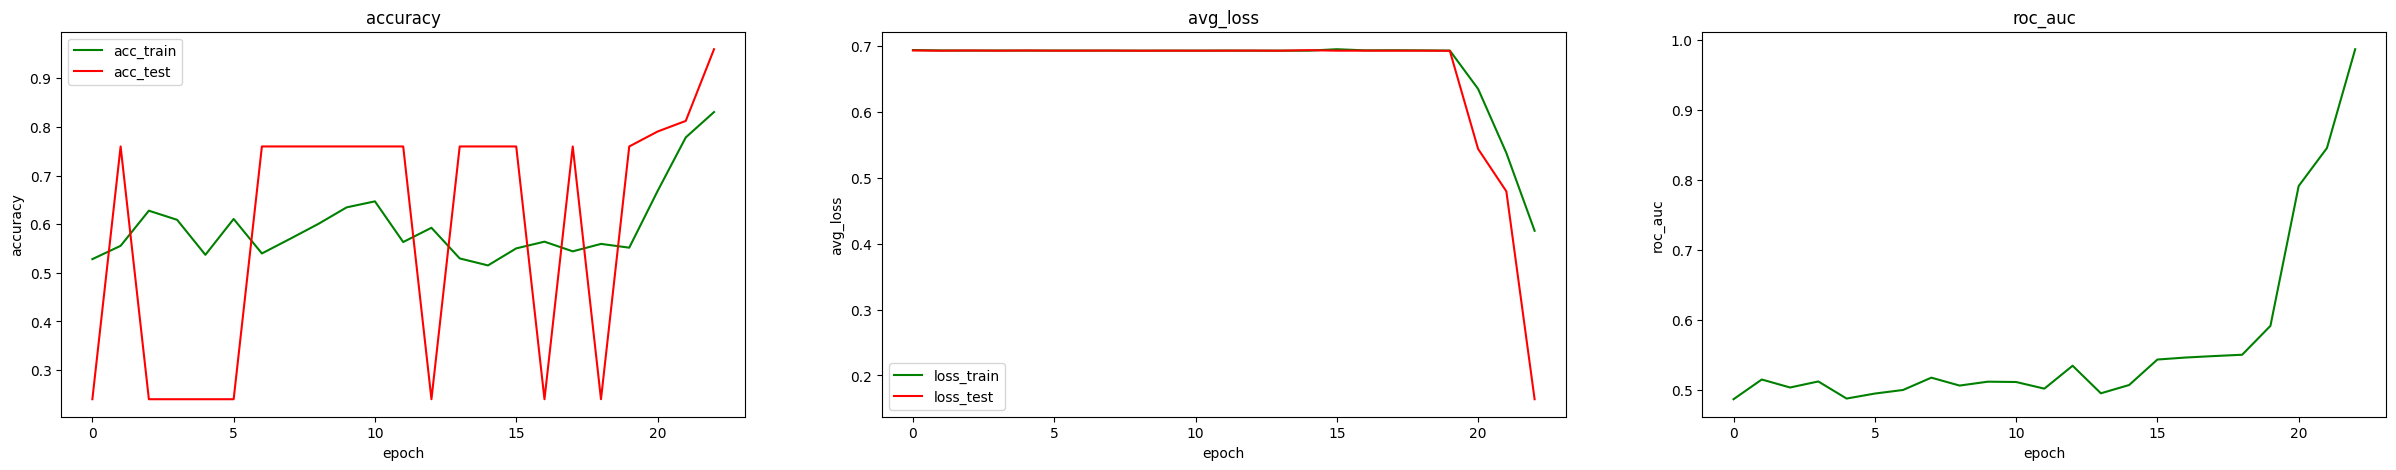

In [1132]:
fig, axs = plt.subplots(1,3, figsize = (30,5))
epoch_lstm = 23
axs[0].plot(range(epoch_lstm), acc_train_lstm, color = "green", label = "acc_train")
axs[0].plot(range(epoch_lstm), acc_test_lstm, color = "red", label = "acc_test")
axs[0].set_xlabel("epoch")
axs[0].set_ylabel("accuracy")
axs[0].set_title("accuracy")
axs[0].legend();

axs[1].plot(range(epoch_lstm), avg_loss_train_lstm, color = "green", label = "loss_train")
axs[1].plot(range(epoch_lstm), avg_loss_test_lstm, color = "red", label = "loss_test")
axs[1].set_xlabel("epoch")
axs[1].set_ylabel("avg_loss")
axs[1].set_title("avg_loss")
axs[1].legend();

axs[2].plot(range(epoch_lstm), roc_auc_lstm, color = "green")
axs[2].set_xlabel("epoch")
axs[2].set_ylabel("roc_auc")
axs[2].set_title("roc_auc");

In [1125]:
class GRU_net(nn.Module):
    def __init__(self, hidden_dim, output_dim, n_layers, embedded_matrix, dropout):
        super().__init__()
        self.embedded = nn.Embedding.from_pretrained(embedded_matrix,  freeze=False, padding_idx=0)
        self.dropout1 = nn.Dropout(dropout)
        self.gru = nn.GRU(embedded_matrix.size(1), hidden_dim, n_layers, batch_first = True, dropout = dropout if n_layers > 1 else 0)
        self.dropout2 = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedded(x)
        x=self.dropout1(x)
        output, hidden= self.gru(x)
        last_output = output[:,-1,:]
        x = self.dropout2(last_output)
        
        return self.fc(x)

In [1126]:
model2 = GRU_net(1024, 2, 1, embedded_matrix , 0.4)
model2 = model2.to(device)
class_weights =torch.tensor([1/0.76,1/0.24]).to(device)
loss_f = nn.CrossEntropyLoss(weight=class_weights)
optimizer2 = torch.optim.AdamW(model2.parameters(), lr = 1e-3, weight_decay=1e-3)
early_stop_value = 5
min_epochs =30

In [1127]:
acc_train_gru, acc_test_gru, avg_loss_train_gru, avg_loss_test_gru, roc_auc_gru = modeling(model2, train_iterator, test_iterator, loss_f, optimizer2, early_stop_value, min_epochs)

 for 1 train_accuracy :  0.52597, loss_avg:  0.69402
test_accuracy :  0.24027, loss_avg:  0.69341, ROC_AUC :  0.49904, F1 :  0.38745
 for 2 train_accuracy :  0.55937, loss_avg:  0.69366
test_accuracy :  0.24027, loss_avg:  0.69328, ROC_AUC :  0.49383, F1 :  0.38745
 for 3 train_accuracy :  0.55188, loss_avg:  0.69366
test_accuracy :  0.75973, loss_avg:  0.69339, ROC_AUC :  0.51231, F1 :  0.00000
 for 4 train_accuracy :  0.56041, loss_avg:  0.69356
test_accuracy :  0.75973, loss_avg:  0.69314, ROC_AUC :  0.52155, F1 :  0.00000
 for 5 train_accuracy :  0.57276, loss_avg:  0.69349
test_accuracy :  0.75973, loss_avg:  0.69317, ROC_AUC :  0.50225, F1 :  0.00000
 for 6 train_accuracy :  0.58780, loss_avg:  0.69371
test_accuracy :  0.75973, loss_avg:  0.69315, ROC_AUC :  0.48351, F1 :  0.00000
 for 7 train_accuracy :  0.51154, loss_avg:  0.69345
test_accuracy :  0.75973, loss_avg:  0.69328, ROC_AUC :  0.47401, F1 :  0.00000
 for 8 train_accuracy :  0.53428, loss_avg:  0.76085
test_accuracy : 

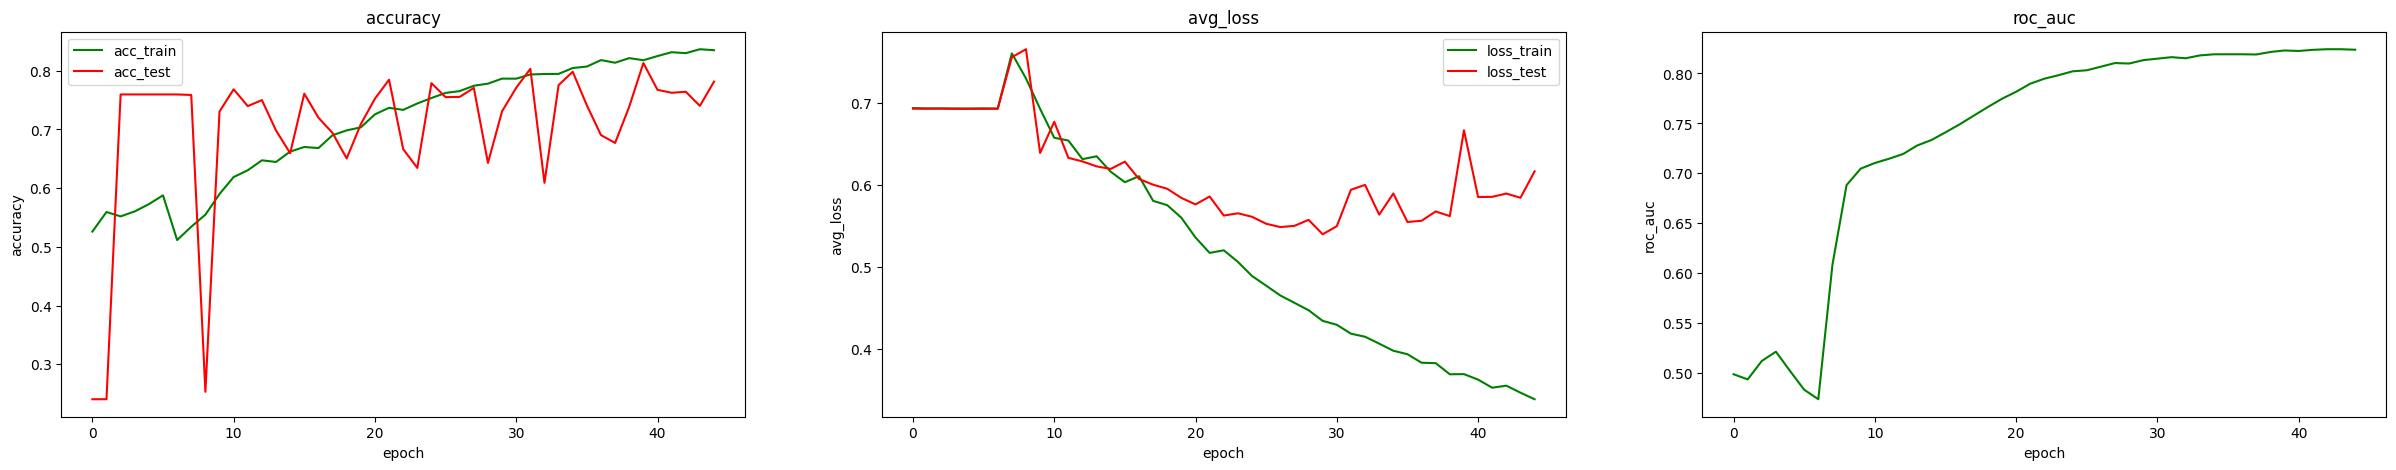

In [1133]:
fig, axs = plt.subplots(1,3, figsize = (30,5))
epoch_gru = 45
axs[0].plot(range(epoch_gru), acc_train_gru, color = "green", label = "acc_train")
axs[0].plot(range(epoch_gru), acc_test_gru, color = "red", label = "acc_test")
axs[0].set_xlabel("epoch")
axs[0].set_ylabel("accuracy")
axs[0].set_title("accuracy")
axs[0].legend();

axs[1].plot(range(epoch_gru), avg_loss_train_gru, color = "green", label = "loss_train")
axs[1].plot(range(epoch_gru), avg_loss_test_gru, color = "red", label = "loss_test")
axs[1].set_xlabel("epoch")
axs[1].set_ylabel("avg_loss")
axs[1].set_title("avg_loss")
axs[1].legend();

axs[2].plot(range(epoch_gru), roc_auc_gru, color = "green")
axs[2].set_xlabel("epoch")
axs[2].set_ylabel("roc_auc")
axs[2].set_title("roc_auc");